## 1.データ、ライブラリのimport

In [1634]:
import pandas as pd
import numpy as np
import glob
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import matplotlib.pyplot as plt
import re

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set()

from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [1635]:
pd.set_option('display.max_rows', 500)

In [1636]:
test = pd.read_csv('/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/test.csv')

In [1637]:
path ='/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/train'
all_files = glob.glob(path +'/*.csv')
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

train =pd.concat(li, axis =0, ignore_index = True)

/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2.EDA

In [1638]:
print(test.shape)

(23204, 27)


In [1639]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          23204 non-null  int64  
 1   種類          23204 non-null  object 
 2   地域          0 non-null      float64
 3   市区町村コード     23204 non-null  int64  
 4   都道府県名       23204 non-null  object 
 5   市区町村名       23204 non-null  object 
 6   地区名         23202 non-null  object 
 7   最寄駅：名称      23191 non-null  object 
 8   最寄駅：距離（分）   23191 non-null  object 
 9   間取り         22035 non-null  object 
 10  面積（㎡）       23204 non-null  object 
 11  土地の形状       0 non-null      float64
 12  間口          0 non-null      float64
 13  延床面積（㎡）     0 non-null      float64
 14  建築年         22466 non-null  object 
 15  建物の構造       21780 non-null  object 
 16  用途          16466 non-null  object 
 17  今後の利用目的     22223 non-null  object 
 18  前面道路：方位     0 non-null      float64
 19  前面道路：種類     0 non-null   

In [1640]:
print(train.iloc[:,1:6])

              種類  地域  市区町村コード 都道府県名   市区町村名
0       中古マンション等 NaN    40131   福岡県   福岡市東区
1       中古マンション等 NaN    40135   福岡県   福岡市西区
2       中古マンション等 NaN    40134   福岡県   福岡市南区
3       中古マンション等 NaN    40131   福岡県   福岡市東区
4       中古マンション等 NaN    40133   福岡県  福岡市中央区
...          ...  ..      ...   ...     ...
662794  中古マンション等 NaN    12204   千葉県     船橋市
662795  中古マンション等 NaN    12232   千葉県     白井市
662796  中古マンション等 NaN    12227   千葉県     浦安市
662797  中古マンション等 NaN    12216   千葉県    習志野市
662798  中古マンション等 NaN    12103   千葉県  千葉市稲毛区

[662799 rows x 5 columns]


In [1641]:
print(train.iloc[:,6:11])

        地区名  最寄駅：名称 最寄駅：距離（分）   間取り 面積（㎡）
0        三苫      三苫       NaN  ２ＬＤＫ    50
1        福重      姪浜        25   ３ＤＫ    50
2        長丘  高宮(福岡)   30分?60分  ３ＬＤＫ    70
3        原田      柚須        21  ２ＬＤＫ    70
4        赤坂  赤坂(福岡)        13  ３ＬＤＫ    65
...     ...     ...       ...   ...   ...
662794   浜町     南船橋         5  ４ＬＤＫ    90
662795   南山      白井         6  ４ＬＤＫ   145
662796   入船     新浦安        11  ５ＬＤＫ   100
662797  津田沼     津田沼        14  ２ＬＤＫ    55
662798  小仲台      稲毛         2  ２ＬＤＫ    65

[662799 rows x 5 columns]


In [1642]:
print(train.iloc[:,11:16])

        土地の形状  間口  延床面積（㎡）    建築年 建物の構造
0         NaN NaN      NaN   平成3年    ＲＣ
1         NaN NaN      NaN  昭和58年    ＲＣ
2         NaN NaN      NaN  平成13年    ＲＣ
3         NaN NaN      NaN  昭和64年    ＲＣ
4         NaN NaN      NaN  平成12年   ＳＲＣ
...       ...  ..      ...    ...   ...
662794    NaN NaN      NaN  平成19年    ＲＣ
662795    NaN NaN      NaN   平成3年   ＳＲＣ
662796    NaN NaN      NaN  昭和56年   NaN
662797    NaN NaN      NaN  昭和49年    ＲＣ
662798    NaN NaN      NaN  平成21年    ＲＣ

[662799 rows x 5 columns]


In [1643]:
print(train.iloc[:,16:21])

         用途 今後の利用目的  前面道路：方位  前面道路：種類  前面道路：幅員（ｍ）
0        住宅     NaN      NaN      NaN         NaN
1       NaN      住宅      NaN      NaN         NaN
2        住宅     NaN      NaN      NaN         NaN
3        住宅     NaN      NaN      NaN         NaN
4        住宅     NaN      NaN      NaN         NaN
...     ...     ...      ...      ...         ...
662794   住宅     NaN      NaN      NaN         NaN
662795   住宅      住宅      NaN      NaN         NaN
662796  NaN      住宅      NaN      NaN         NaN
662797   住宅     NaN      NaN      NaN         NaN
662798   住宅      住宅      NaN      NaN         NaN

[662799 rows x 5 columns]


In [1644]:
print(train.iloc[:,21:27])

                都市計画  建ぺい率（％）  容積率（％）        取引時点   改装 取引の事情等
0                NaN      NaN     NaN  2006年第３四半期  未改装    NaN
1              準住居地域     60.0   200.0  2019年第１四半期  改装済    NaN
2            第２種住居地域     60.0   200.0  2012年第４四半期  改装済    NaN
3               工業地域     60.0   200.0  2011年第２四半期  未改装    NaN
4            第１種住居地域     60.0   200.0  2010年第３四半期  NaN    NaN
...              ...      ...     ...         ...  ...    ...
662794          商業地域     80.0   400.0  2007年第３四半期  未改装    NaN
662795  第１種中高層住居専用地域     60.0   200.0  2014年第２四半期  未改装    NaN
662796   第１種低層住居専用地域     50.0   100.0  2018年第１四半期  未改装    NaN
662797  第２種中高層住居専用地域     60.0   200.0  2010年第１四半期  未改装    NaN
662798          商業地域     80.0   400.0  2016年第４四半期  未改装    NaN

[662799 rows x 6 columns]


## 3.データの整理

### 3.1不必要データの削除

#### 3.1-1不必要データの削除
1.データが無いもの = 地域、土地の形状、間口、延床面積（㎡）、前面道路：方位、前面道路：種類、前面道路：幅員（ｍ）
2.全種類同じデータのもの = ID、種類

In [1645]:
train = train.drop(['地域','土地の形状','間口','延床面積（㎡）','前面道路：方位','前面道路：種類','前面道路：幅員（ｍ）'],axis='columns')
test = test.drop(['地域','土地の形状','間口','延床面積（㎡）','前面道路：方位','前面道路：種類','前面道路：幅員（ｍ）'],axis='columns')

In [1646]:
train = train.drop(['ID','種類'], axis = 'columns')
test = test.drop(['ID','種類'], axis = 'columns')

In [1647]:
train.isnull().sum()

市区町村コード              0
都道府県名                0
市区町村名                0
地区名                658
最寄駅：名称            2650
最寄駅：距離（分）        23076
間取り              22954
面積（㎡）                0
建築年              19127
建物の構造            15595
用途               53943
今後の利用目的         363472
都市計画             18997
建ぺい率（％）          23050
容積率（％）           23050
取引時点                 0
改装               60076
取引の事情等          644339
取引価格（総額）_log         0
dtype: int64

#### 3.1-2['取引の事情等']に関しては、欠損箇所が多い為、そもそものカラムを外す
※644339/662798 欠損確率97.2%

In [1648]:
train = train.drop(['取引の事情等'], axis ='columns')
test = test.drop(['取引の事情等'], axis ='columns')

In [1649]:
train.nunique()

市区町村コード           618
都道府県名              47
市区町村名             618
地区名             12090
最寄駅：名称           3846
最寄駅：距離（分）          34
間取り                63
面積（㎡）             196
建築年                77
建物の構造              12
用途                 22
今後の利用目的             4
都市計画               16
建ぺい率（％）             6
容積率（％）             17
取引時点               60
改装                  2
取引価格（総額）_log      381
dtype: int64

#### 3.1-3['間取り']に関しては、オープンフロア、スタジオを削除します。※(5Ldk以上のものも、マンションではない可能性が高い為、後々削除の可能性あり)

In [1650]:
train = train[train['間取り'] != 'オープンフロア']


In [1651]:
train = train[train['間取り'] != 'スタジオ']


#### 3.1-4['面積（㎡)']に関しては、極端に大きなもの(2000㎡)以上のものを削除します。

In [1652]:
train['面積（㎡）'].value_counts()

70         73241
65         67659
60         53924
75         49338
20         42944
55         40601
80         33613
50         28662
15         25947
85         20462
25         19679
45         17983
65         13413
70         13405
90         12930
40         12561
60         11404
20         11333
30         10055
35          9611
95          9413
75          9299
55          8074
80          7271
25          5788
15          5718
50          5377
100         4603
85          4519
45          3110
90          2905
40          2792
105         2651
30          2510
35          2141
95          1934
110         1635
115         1177
10          1002
100          957
120          790
105          583
125          564
110          392
130          375
10           301
115          296
135          291
145          211
120          195
140          179
125          141
130          139
150          127
155          123
135           79
160           79
140           72
180           

In [1653]:
train = train[train['面積（㎡）'] != '2000㎡以上']


#### 3.1-5['今後の利用目的']に関しては、欠損となっている箇所を住宅で全て埋めます。

In [1654]:
train['今後の利用目的'] = train['今後の利用目的'].fillna('住宅')
test['今後の利用目的'] = test['今後の利用目的'].fillna('住宅')

In [1655]:
train['今後の利用目的'] .value_counts()
test['今後の利用目的'] .value_counts()

住宅     21660
その他     1214
事務所      262
店舗        68
Name: 今後の利用目的, dtype: int64

In [1656]:
train= train[train['今後の利用目的'] != '店舗']


#### 3.1-6['最寄駅：距離（分）']に関して整形

In [1657]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [1658]:
train['最寄駅：距離（分）'] = train['最寄駅：距離（分）'].map(normalize_moyori)
test['最寄駅：距離（分）'] = test['最寄駅：距離（分）'].map(normalize_moyori)

In [1659]:
print(normalize_moyori('30分?60分'))

45


In [1660]:
train['最寄駅：距離（分）'].value_counts()

6.0      52513
4.0      50472
5.0      46930
8.0      45907
3.0      44132
9.0      39816
7.0      33425
45.0     32992
10.0     32777
11.0     31779
2.0      27781
13.0     23669
1.0      19928
14.0     19439
15.0     19205
12.0     15663
16.0     14833
18.0     12076
19.0     10894
20.0      9219
21.0      7394
23.0      6888
25.0      6374
24.0      5081
28.0      4258
26.0      4123
75.0      3743
29.0      3713
0.0       3704
17.0      2571
22.0      1101
120.0      855
105.0      710
27.0       418
Name: 最寄駅：距離（分）, dtype: int64

#### 3.1-7['建築年']に関して、整形

In [1661]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [1662]:
train['建築年'] = train['建築年'].map(convert_wareki_to_seireki)
test['建築年'] = test['建築年'].map(convert_wareki_to_seireki)

In [1663]:
train['建築年'].value_counts()

2008.0    22709
1991.0    22523
2006.0    22459
2007.0    22183
1998.0    21372
2003.0    21355
2005.0    21184
2000.0    21125
1995.0    21054
1990.0    20399
2002.0    20100
1996.0    20064
1997.0    19391
2001.0    19347
1999.0    19110
2004.0    18992
1989.0    17245
1992.0    16408
1988.0    16303
2009.0    16018
1994.0    14671
1987.0    14152
1984.0    13899
1985.0    13370
1986.0    12891
1974.0    11879
1993.0    11005
2010.0    10251
1979.0     8835
1982.0     8825
1980.0     8591
2012.0     8438
1981.0     8290
2011.0     7982
1973.0     7491
1983.0     7127
2013.0     7121
1978.0     6916
1975.0     6574
2014.0     5922
1977.0     5652
1976.0     5299
2015.0     5073
1972.0     4912
1971.0     4373
1970.0     3761
2016.0     3445
2017.0     2259
1969.0     2225
1968.0     2123
2018.0     1484
2019.0     1171
1967.0      891
1966.0      577
1945.0      558
2020.0      227
1965.0      194
1964.0      150
1963.0       48
1962.0       29
1959.0       21
1947.0       20
1961.0  

### 3-2欠損値を含む行を全て削除
※結界によっては修正の余地あり。

In [1664]:
train = train.dropna(how = 'any')


In [1665]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   市区町村コード    23204 non-null  int64  
 1   都道府県名      23204 non-null  object 
 2   市区町村名      23204 non-null  object 
 3   地区名        23202 non-null  object 
 4   最寄駅：名称     23191 non-null  object 
 5   最寄駅：距離（分）  23191 non-null  float64
 6   間取り        22035 non-null  object 
 7   面積（㎡）      23204 non-null  object 
 8   建築年        22466 non-null  float64
 9   建物の構造      21780 non-null  object 
 10  用途         16466 non-null  object 
 11  今後の利用目的    23204 non-null  object 
 12  都市計画       22888 non-null  object 
 13  建ぺい率（％）    22768 non-null  float64
 14  容積率（％）     22768 non-null  float64
 15  取引時点       23204 non-null  object 
 16  改装         20084 non-null  object 
dtypes: float64(4), int64(1), object(12)
memory usage: 3.0+ MB


### 3-3 LabelEncoding

In [1666]:
train = train.astype({'面積（㎡）':int})


In [1667]:
train_object = train.select_dtypes(include = 'object')
test_object = test.select_dtypes(include = 'object')

In [1668]:
train_object

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装
2,福岡県,福岡市南区,長丘,高宮(福岡),３ＬＤＫ,ＲＣ,住宅,住宅,第２種住居地域,2012年第４四半期,改装済
3,福岡県,福岡市東区,原田,柚須,２ＬＤＫ,ＲＣ,住宅,住宅,工業地域,2011年第２四半期,未改装
6,福岡県,福岡市中央区,荒戸,大濠公園,１ＬＤＫ,ＳＲＣ,住宅,住宅,商業地域,2016年第１四半期,改装済
7,福岡県,福岡市中央区,大手門,大濠公園,１Ｋ,ＳＲＣ,住宅,住宅,商業地域,2019年第１四半期,改装済
9,福岡県,福岡市中央区,高砂,西鉄平尾,１Ｋ,ＲＣ,住宅,住宅,商業地域,2009年第３四半期,未改装
...,...,...,...,...,...,...,...,...,...,...,...
662793,千葉県,市川市,南行徳,南行徳,２ＬＤＫ,ＳＲＣ,住宅,住宅,第１種住居地域,2012年第１四半期,未改装
662794,千葉県,船橋市,浜町,南船橋,４ＬＤＫ,ＲＣ,住宅,住宅,商業地域,2007年第３四半期,未改装
662795,千葉県,白井市,南山,白井,４ＬＤＫ,ＳＲＣ,住宅,住宅,第１種中高層住居専用地域,2014年第２四半期,未改装
662797,千葉県,習志野市,津田沼,津田沼,２ＬＤＫ,ＲＣ,住宅,住宅,第２種中高層住居専用地域,2010年第１四半期,未改装


In [1669]:
train_numeric = train.select_dtypes(exclude = 'object')
test_numeric = test.select_dtypes(exclude = 'object')

In [1670]:
train_numeric

,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
2,40134,45.0,70,2001.0,60.0,200.0,7.255273
3,40131,21.0,70,1989.0,60.0,200.0,6.740363
6,40133,5.0,50,1987.0,80.0,400.0,7.204120
7,40133,2.0,20,1996.0,80.0,400.0,6.838849
9,40133,7.0,30,2008.0,80.0,400.0,7.255273
...,...,...,...,...,...,...,...
662793,12203,11.0,55,1977.0,60.0,200.0,7.146128
662794,12204,5.0,90,2007.0,80.0,400.0,7.623249
662795,12232,6.0,145,1991.0,60.0,200.0,7.380211
662797,12216,14.0,55,1974.0,60.0,200.0,6.869232


In [1671]:
for c in train_object:
    le = LabelEncoder()
    le.fit(train_object[c])
    train_object[c] = le.transform(train_object[c])
    train_object

<ipython-input-1671-b823236a08d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_object[c] = le.transform(train_object[c])


In [1672]:
for c in test_object:
    le = LabelEncoder()
    le.fit(test_object[c])
    test_object[c] = le.transform(test_object[c])
    test_object

<ipython-input-1672-dcff0da179f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_object[c] = le.transform(test_object[c])


In [1673]:
train_object

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装
2,34,477,10977,3588,35,4,4,2,12,29,0
3,34,481,2813,2193,23,4,4,2,1,23,1
6,34,476,9687,1181,9,7,4,2,0,42,0
7,34,476,3982,1181,4,7,4,2,0,54,0
9,34,476,11522,3220,4,4,4,2,0,16,1
...,...,...,...,...,...,...,...,...,...,...,...
662793,5,281,2695,871,23,7,4,2,9,26,1
662794,5,509,7866,867,45,4,4,2,0,8,1
662795,5,445,2560,2665,45,7,4,2,7,35,1
662797,5,508,7787,2429,23,4,4,2,10,18,1


## 4.1モデルの作成

In [1674]:
train = pd.concat([train_object,train_numeric], axis = 1)
test = pd.concat([test_object,test_numeric], axis = 1)

In [1675]:
train

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
2,34,477,10977,3588,35,4,4,2,12,29,0,40134,45.0,70,2001.0,60.0,200.0,7.255273
3,34,481,2813,2193,23,4,4,2,1,23,1,40131,21.0,70,1989.0,60.0,200.0,6.740363
6,34,476,9687,1181,9,7,4,2,0,42,0,40133,5.0,50,1987.0,80.0,400.0,7.204120
7,34,476,3982,1181,4,7,4,2,0,54,0,40133,2.0,20,1996.0,80.0,400.0,6.838849
9,34,476,11522,3220,4,4,4,2,0,16,1,40133,7.0,30,2008.0,80.0,400.0,7.255273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662793,5,281,2695,871,23,7,4,2,9,26,1,12203,11.0,55,1977.0,60.0,200.0,7.146128
662794,5,509,7866,867,45,4,4,2,0,8,1,12204,5.0,90,2007.0,80.0,400.0,7.623249
662795,5,445,2560,2665,45,7,4,2,7,35,1,12232,6.0,145,1991.0,60.0,200.0,7.380211
662797,5,508,7787,2429,23,4,4,2,10,18,1,12216,14.0,55,1974.0,60.0,200.0,6.869232


In [1676]:
train = train.dropna(how = 'any')


In [1677]:
test

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,面積（㎡）,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,市区町村コード,最寄駅：距離（分）,建築年,建ぺい率（％）,容積率（％）
0,4,300,2129,2288,8,41,4,3,2,0,1,1,1101,2.0,1991.0,80.0,400.0
1,4,300,2129,2288,8,41,4,3,0,0,0,1,1101,2.0,1991.0,80.0,400.0
2,4,300,2129,2288,14,44,4,3,2,0,0,0,1101,2.0,1989.0,80.0,400.0
3,4,300,2129,2288,14,51,2,11,2,0,0,0,1101,3.0,1997.0,80.0,400.0
4,4,300,2129,2288,5,22,2,11,2,0,0,1,1101,3.0,1981.0,80.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23199,28,381,2294,2631,19,53,2,11,2,7,0,1,47208,NaN,2009.0,60.0,200.0
23200,28,361,2251,2631,15,47,2,11,2,7,0,0,47211,NaN,1989.0,60.0,200.0
23201,28,361,2132,2631,14,36,2,11,2,8,0,2,47211,NaN,1991.0,50.0,100.0
23202,28,361,3835,2631,14,46,2,11,2,3,0,1,47211,NaN,1984.0,70.0,200.0


In [1678]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499179 entries, 2 to 662798
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   都道府県名         499179 non-null  int64  
 1   市区町村名         499179 non-null  int64  
 2   地区名           499179 non-null  int64  
 3   最寄駅：名称        499179 non-null  int64  
 4   間取り           499179 non-null  int64  
 5   建物の構造         499179 non-null  int64  
 6   用途            499179 non-null  int64  
 7   今後の利用目的       499179 non-null  int64  
 8   都市計画          499179 non-null  int64  
 9   取引時点          499179 non-null  int64  
 10  改装            499179 non-null  int64  
 11  市区町村コード       499179 non-null  int64  
 12  最寄駅：距離（分）     499179 non-null  float64
 13  面積（㎡）         499179 non-null  int64  
 14  建築年           499179 non-null  float64
 15  建ぺい率（％）       499179 non-null  float64
 16  容積率（％）        499179 non-null  float64
 17  取引価格（総額）_log  499179 non-null  float64
dtypes: f

In [1679]:
train.corr()

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
都道府県名,1.000000,0.212408,0.018306,0.071621,-0.176176,0.000461,-0.024869,-0.035533,-0.058769,0.020777,0.014207,-0.042745,0.021940,-0.154519,0.071127,0.044542,0.068938,0.127223
市区町村名,0.212408,1.000000,0.059036,0.213526,0.036573,-0.034300,-0.010314,0.001733,0.060157,-0.008480,-0.011081,0.060250,0.053655,0.035298,-0.018395,-0.085886,-0.094392,0.002441
地区名,0.018306,0.059036,1.000000,0.217750,-0.015817,-0.000299,-0.003700,-0.002311,-0.025424,0.001308,0.002232,0.044695,-0.001417,-0.020827,-0.011870,0.015422,0.025009,-0.000934
最寄駅：名称,0.071621,0.213526,0.217750,1.000000,-0.020532,0.002602,-0.003736,-0.003354,-0.001517,0.006636,-0.000319,0.011169,0.027079,-0.017909,-0.011498,0.000781,0.002301,-0.002617
間取り,-0.176176,0.036573,-0.015817,-0.020532,1.000000,-0.027827,0.050185,0.109859,0.209703,-0.051015,-0.042729,0.107788,0.205154,0.832841,-0.004035,-0.334968,-0.413479,0.246019
建物の構造,0.000461,-0.034300,-0.000299,0.002602,-0.027827,1.000000,-0.022775,-0.011812,-0.242279,-0.032944,-0.059637,0.052582,-0.072239,-0.029119,-0.260025,0.279449,0.296896,-0.089595
用途,-0.024869,-0.010314,-0.003700,-0.003736,0.050185,-0.022775,1.000000,0.032092,0.031025,-0.003242,-0.000953,0.009520,0.016839,0.060244,0.021696,-0.034098,-0.039957,0.043551
今後の利用目的,-0.035533,0.001733,-0.002311,-0.003354,0.109859,-0.011812,0.032092,1.000000,0.034364,-0.156882,-0.048054,0.006438,0.019905,0.106258,-0.001924,-0.050045,-0.064006,0.036402
都市計画,-0.058769,0.060157,-0.025424,-0.001517,0.209703,-0.242279,0.031025,0.034364,1.000000,-0.022572,-0.037708,-0.039113,0.162749,0.177712,-0.083665,-0.409026,-0.627585,-0.024322
取引時点,0.020777,-0.008480,0.001308,0.006636,-0.051015,-0.032944,-0.003242,-0.156882,-0.022572,1.000000,-0.012823,0.016156,-0.037202,-0.028873,0.113816,0.036032,0.042307,0.095824


In [1680]:
import lightgbm as lgb
from sklearn.metrics import log_loss
y = train['取引価格（総額）_log']
X = train.drop('取引価格（総額）_log', axis =1)

In [1681]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =1)

In [1682]:
X_train.describe()

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）
count,399343.000000,399343.000000,399343.000000,399343.000000,399343.000000,399343.00000,399343.000000,399343.000000,399343.000000,399343.000000,399343.000000,399343.000000,399343.00000,399343.000000,399343.000000,399343.000000,399343.000000
mean,19.779989,301.479144,5798.801782,1882.919012,26.493185,4.89184,3.992345,1.953992,6.135836,31.195060,0.721024,18407.290404,11.72291,59.118152,1995.067979,67.337402,297.188682
std,11.491954,160.381439,3398.701892,1070.238678,13.483351,1.38524,0.220384,0.294358,4.431608,14.958987,0.448496,9420.169660,12.01820,23.256991,11.388410,10.355209,145.142680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1101.000000,0.00000,10.000000,1945.000000,30.000000,50.000000
25%,9.000000,172.000000,2741.000000,930.000000,15.000000,4.00000,4.000000,2.000000,0.000000,19.000000,0.000000,13106.000000,5.00000,50.000000,1987.000000,60.000000,200.000000
50%,26.000000,313.000000,5946.000000,1900.000000,35.000000,4.00000,4.000000,2.000000,7.000000,31.000000,1.000000,14103.000000,8.00000,65.000000,1996.000000,60.000000,200.000000
75%,26.000000,426.000000,8617.000000,2804.000000,35.000000,7.00000,4.000000,2.000000,9.000000,43.000000,1.000000,27113.000000,14.00000,75.000000,2004.000000,80.000000,400.000000
max,46.000000,600.000000,11824.000000,3724.000000,60.000000,10.00000,14.000000,2.000000,14.000000,59.000000,1.000000,47208.000000,120.00000,970.000000,2020.000000,80.000000,1300.000000


In [1683]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(399343, 17)
(99836, 17)
(399343,)
(99836,)


In [1684]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [1685]:
pred= model.predict(X_test)
print(np.sqrt(MSE(y_test, pred)))

0.1447968455928931


In [1686]:
y_test.describe()

count    99836.000000
mean         7.222391
std          0.348944
min          3.079181
25%          7.041393
50%          7.278754
75%          7.462398
max          9.505150
Name: 取引価格（総額）_log, dtype: float64

In [1687]:
np.shape(pred)

(99836,)

/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/

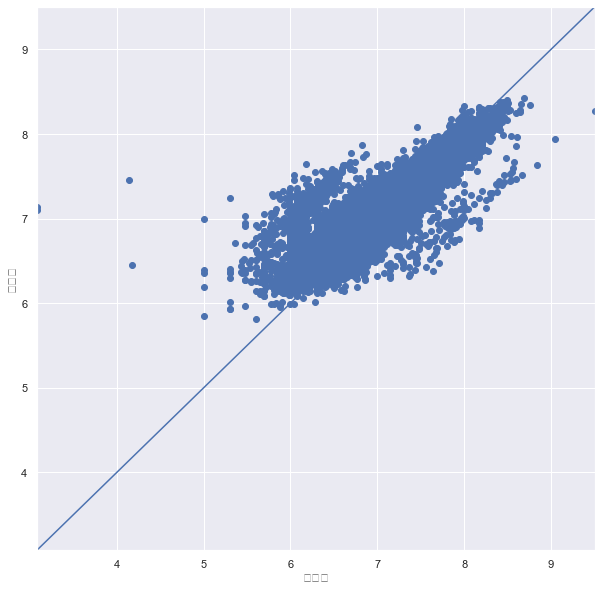

In [1688]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(y_test,pred)

# 3.値域を揃える為に、y_test、predの両方を見た上での最小値と最大値を求める
min_value = 3.079181
max_value = 9.505150

# 4.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 5.対角線を描く
plt.plot([min_value, max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

In [1689]:
Z = test
test_pred = model.predict(Z)

In [1690]:
test_pred

array([6.29524057, 6.3468593 , 6.34844852, ..., 6.29850704, 6.27140931,
       7.06144761])

In [1691]:
test_pred = pd.DataFrame(test_pred)

In [1692]:
test_pred

,0
0,6.295241
1,6.346859
2,6.348449
3,6.837613
4,6.335627
...,...
23199,7.012078
23200,6.301339
23201,6.298507
23202,6.271409


In [1693]:
sample_submission = pd.read_csv("/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/sample_submission.csv", index_col=0, header=None) # 応募用サンプルファイル

In [1694]:
sample_submission
sample_submission[1] = test_pred

In [1695]:
test_pred.to_csv('/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/test_submission(自作).csv',header = None)

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()

In [ ]:
print(matplotlib.get_configdir())

In [ ]:
print(matplotlib.rcParams['font.family'])

In [1376]:
plt.rcParams['font.family'] = 'Hiragino sans'

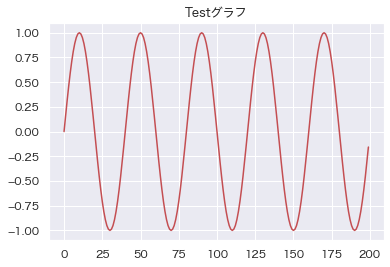

In [238]:
s = np.sin(np.pi*np.arange(0.0,10.0,0.05))
t =plt.plot(s,color='r')
plt.title('Testグラフ')
plt.show()

<AxesSubplot:ylabel='都道府県名'>

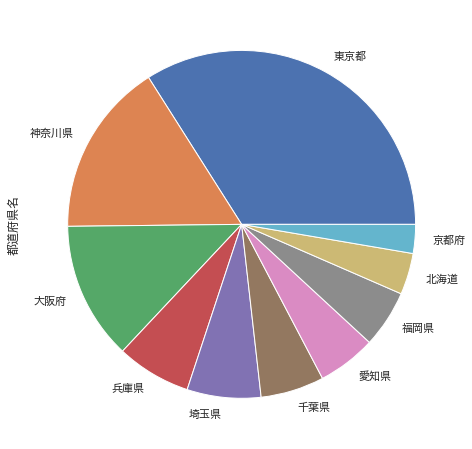

In [239]:
train['都道府県名'].value_counts()[0:10].plot(kind = 'pie',figsize =(8,8))

In [255]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
oe = preprocessing.OrdinalEncoder()
train = oe.fit_transform(train[['都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '取引時点', '改装', '取引の事情等']].values)
print('エンコード結果: ', encoded)

ValueError: Input contains NaN

In [241]:
X = train.drop(['取引価格（総額）_log'], axis = 1)
y = train['取引価格（総額）_log']
X.shape, y.shape

((662799, 18), (662799,))

In [245]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((530239, 18), (530239,), (132560, 18), (132560,))

In [248]:
va_X,va_y = train_test_split(test, test_size = 0.2,random_state = 1)
va_X.shape, va_y.shape

((18563, 18), (4641, 18))

In [249]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

In [251]:
params = {'obhective' : 'binary', 'seed':71, 'verbose':0, 'metrics': 'binary_logloss'}
num_round =100

In [253]:
categorical_features = ['product', 'medical_info_b2', 'medical_info_b3']
model = lgb.train(params, lgb_train, num_boost_round = num_round,categorical_feature = categorical_features,valid_names=['train','valid'],valid_sets = [lgb_train,lgb_test])

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: 都道府県名, 市区町村名, 地区名, 最寄駅：名称, 最寄駅：距離（分）, 間取り, 面積（㎡）, 建築年, 建物の構造, 用途, 今後の利用目的, 都市計画, 取引時点, 改装, 取引の事情等

In [132]:
lgb_train = lgb.Dataset(try_X, ty_y)
lgb_eval = lgb.Dataset(va_X, va_y)

NameError: name 'try_X' is not defined